# PROJETO 4 - FORMAÇÃO CIENTISTA DE DADOS 3.0 

# DANILO TEMERLOGLOU DE ABREU

# Através da análise de Tweets sobre o ChatGPT você deve construir um processo de análise que permita identificar o sentimento que predomina, especialmente no Twitter, sobre o ChatGPT

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


# 1 - Instalação dos pacotes necessários

In [2]:
#!pip install -q -U nltk
#!pip install -q -U textblob
#!pip install vaderSentiment
#!pip install -q numpy == 1.21.6
#!python -m pip install --upgrade pip
#!pip install -q spacy
#!pip install vaderSentiment
#!pip install pyspark
#!pip install wordcloud

# 2 - Criando ambiente

In [3]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# 3 - Importando os pacotes

In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.types import FloatType
from pyspark.sql.types import StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
import datetime



#import numpy as np
#import spacy
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from bs4 import BeautifulSoup # para o pré-processamento
#from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
#from pyspark.ml.classification import NaiveBayes
#from pyspark.ml import Pipeline
#from pyspark.sql.functions import col

# 4 - Versões dos pacotes usados neste jupyter notebook

In [5]:
%reload_ext watermark
%watermark -a "Danilo Temerloglou de Abreu" --iversions
# Grava o horário inicial da execução do programa
inicio = datetime.datetime.now()
print("Este programa foi executado em: ", inicio)

Author: Danilo Temerloglou de Abreu

pandas    : 1.3.4
seaborn   : 0.12.2
re        : 2.2.1
sys       : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
nltk      : 3.8.1
matplotlib: 3.7.1

Este programa foi executado em:  2024-04-09 11:19:29.324375


# 5 - Inicializando uma sessão do Spark

In [6]:
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# 6 - lendo os dados como dataframe do Spark

In [7]:
df = spark.read.csv('chatgpt1.csv',header=True)
df.show(5)

+----------------------------------------+-------------------+---------------------------+--------+---------+----+--------+----------+----------+------------+---------+----------+--------------+--------+------+-----+-----------+--------------+-------+-------------+
|                                Datetime|           Tweet Id|                       Text|Username|Permalink|User|Outlinks|CountLinks|ReplyCount|RetweetCount|LikeCount|QuoteCount|ConversationId|Language|Source|Media|QuotedTweet|MentionedUsers|hashtag|hastag_counts|
+----------------------------------------+-------------------+---------------------------+--------+---------+----+--------+----------+----------+------------+---------+----------+--------------+--------+------+-----+-----------+--------------+-------+-------------+
|                    2023-01-22 13:44:...|1617156270871699456|ChatGPTで遊ぶの忘れてた！！|    null|     null|null|    null|      null|      null|        null|     null|      null|          null|    null|  null| n

# 7 - Verificando os dados

In [8]:
# Verificando o tipo de dataframe
type(df)

pyspark.sql.dataframe.DataFrame

In [9]:
# Verificando o tamanho do dataframe spark
print((df.count(), len(df.columns)))

(82129, 20)


In [10]:
# Verificando as colunas e tipos de dados
print(df.printSchema())

root
 |-- Datetime: string (nullable = true)
 |-- Tweet Id: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Username: string (nullable = true)
 |-- Permalink: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Outlinks: string (nullable = true)
 |-- CountLinks: string (nullable = true)
 |-- ReplyCount: string (nullable = true)
 |-- RetweetCount: string (nullable = true)
 |-- LikeCount: string (nullable = true)
 |-- QuoteCount: string (nullable = true)
 |-- ConversationId: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Media: string (nullable = true)
 |-- QuotedTweet: string (nullable = true)
 |-- MentionedUsers: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- hastag_counts: string (nullable = true)

None


In [11]:
# Verificando a coluna Text de onde obteremos a análise de sentimentos
df.select('Text').show(5)

+---------------------------+
|                       Text|
+---------------------------+
|ChatGPTで遊ぶの忘れてた！！|
|                       null|
|                       null|
|                       null|
|                       null|
+---------------------------+
only showing top 5 rows



# 8 - Tratamento dos dados

In [12]:
# Removendo valores null/NA
df = df.dropna(subset="Text")

In [13]:
# Verificando algumas linhas
df.select('Text').show(5)

+---------------------------+
|                       Text|
+---------------------------+
|ChatGPTで遊ぶの忘れてた！！|
|       https://twitter.c...|
|       @AlexandrovnaIng ...|
|       Schaut Euch an, w...|
|       https://twitter.c...|
+---------------------------+
only showing top 5 rows



In [14]:
# Verificando o tamanho do dataframe spark após a exclusao de textos nulos/NA
print((df.count(), len(df.columns)))

(67159, 20)


In [15]:
# Instalando um dicionários do NLTK
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Chilov\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
# Comandos para adequar o texto para análise de sentimentos
# Limpa o texto
df_clean = df.select('Text', (lower(regexp_replace('Text', "[^a-zA-Z\\s]", "")).alias('Text_cleaned')))
#df_clean = re.sub(r'[^\w]', ' ', df_clean)

# Tokeniza o texto
tokenizer = Tokenizer(inputCol='Text_cleaned', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('words_clean')

# Aplica stemização ao texto
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('words_stemmed')

# Filtra comprimento de palavras maior que 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))

In [17]:
# Verificando o tipo de dataframe
type(df_final_words)

pyspark.sql.dataframe.DataFrame

In [18]:
# Verificando as colunas resultantes
df_final_words.columns

['words_stemmed', 'words']

In [19]:
# Verificando algumas linhas de uma coluna
df_words_token.select('words_token').show(5)

+--------------------+
|         words_token|
+--------------------+
|           [chatgpt]|
|[httpstwittercomm...|
|[alexandrovnaing,...|
|[schaut, euch, an...|
|[httpstwittercomc...|
+--------------------+
only showing top 5 rows



In [20]:
# Verificando algumas linhas de outra coluna
df_final_words.select('words').show(5)

+--------------------+
|               words|
+--------------------+
|           [chatgpt]|
|[httpstwittercomm...|
|[alexandrovna, pr...|
|[schaut, euch, fo...|
|[httpstwittercomc...|
+--------------------+
only showing top 5 rows



# 9 - Efetuando a análise de sentimentos

In [21]:
# Inicialize o SentimentIntensityAnalyzer do NLTK
sia = SentimentIntensityAnalyzer()

In [22]:
# Cria função que usa o SentimentIntensityAnalyzer para obter a pontuação de polaridade composta
def analyze_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    return score

In [23]:
# Registra a função como uma UDF
analyze_sentiment_udf = udf(analyze_sentiment, FloatType())

# Adicione uma nova coluna 'sentiment' com as pontuações de sentimentos
df_with_sentiment = df_final_words.withColumn("sentiment", analyze_sentiment_udf(df_final_words["words_stemmed"]))

In [24]:
# Cria função que separa a polaridade composta em sentimento positivo, negativo ou neutro
def categorize_sentiment(score):
    if score > 0:
        return "positivo"
    elif score < 0:
        return "negativo"
    else:
        return "neutro"

# Registre a função como uma UDF
categorize_sentiment_udf = udf(categorize_sentiment, StringType())

# Adicione uma nova coluna 'sentiment_category' com as categorias de sentimentos
df_with_sentiment = df_with_sentiment.withColumn("sentiment_category", categorize_sentiment_udf(df_with_sentiment["sentiment"]))

In [25]:
# Cria um dataframe somente com os valores e categoria de sentimento
selected_df = df_with_sentiment.select("sentiment", "sentiment_category")

In [26]:
# Verifica tipo do novo dataframe criado
type(selected_df)

pyspark.sql.dataframe.DataFrame

In [27]:
# Verifica algumas linhas da coluna sentiment_category
selected_df.select('sentiment_category').show(5)

+------------------+
|sentiment_category|
+------------------+
|            neutro|
|            neutro|
|            neutro|
|            neutro|
|            neutro|
+------------------+
only showing top 5 rows



In [28]:
# Cria um dataframe do Pandas para posterior criação de gráficos
df_pandas = selected_df.toPandas()

In [29]:
# Verifica as colunas do dataframe Pandas criado
sorted(df_pandas)

['sentiment', 'sentiment_category']

In [30]:
# Verifica quantidade de sentimentos positivos, negativos e neutros
df_pandas.value_counts()

sentiment  sentiment_category
 0.0000    neutro                67117
 0.4588    positivo                  5
 0.5859    positivo                  4
 0.4215    positivo                  4
-0.6124    negativo                  2
 0.3612    positivo                  2
-0.5574    negativo                  2
 0.5106    positivo                  2
 0.1531    positivo                  2
-0.5859    negativo                  2
 0.2732    positivo                  2
 0.5719    positivo                  1
 0.5423    positivo                  1
 0.4019    positivo                  1
 0.3818    positivo                  1
 0.2500    positivo                  1
 0.3182    positivo                  1
 0.2263    positivo                  1
 0.0772    positivo                  1
-0.1027    negativo                  1
-0.1280    negativo                  1
-0.2960    negativo                  1
-0.3400    negativo                  1
-0.3612    negativo                  1
-0.4767    negativo               

In [31]:
# Verifica numericamente a polarização dos sentimentos
df_pandas['sentiment_category'].value_counts(normalize=True)*100

neutro      99.937462
positivo     0.044670
negativo     0.017868
Name: sentiment_category, dtype: float64

In [32]:
# Cria dataframe com as porcentagens de sentimentos positivos, negativos e neutros
df_sentiment = df_pandas['sentiment_category'].value_counts(normalize=True)*100

Text(0, 0.5, 'Porcentagem (%)')

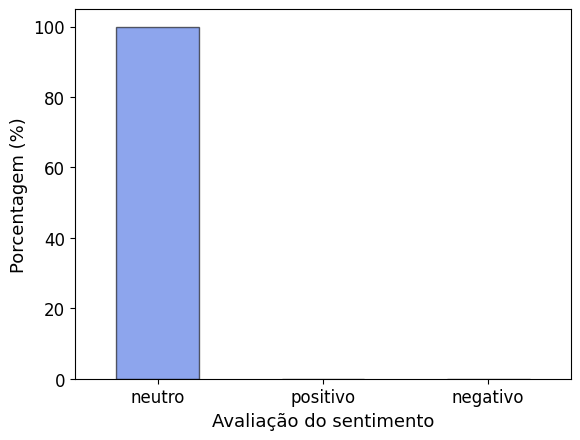

In [33]:
# Cria o gráfico de análise de sentimentos
df_sentiment.plot.bar(color='royalblue', ec='k', alpha=0.6)
plt.xticks(rotation=360, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Avaliação do sentimento', fontsize=13)
plt.ylabel('Porcentagem (%)', fontsize=13)

In [34]:
# Conclusão: No geral, o sentimento que predomina em relação ao chatGPT, mostrado nestes dados, é neutro 